In [ ]:
# 라이브러리 Import
# pip install "spherecluster, sklearn" , numpy, pandas, matplotlib, seaborn, gensim

In [ ]:
!pip uninstall scikit-learn

Found existing installation: scikit-learn 0.21.3
Uninstalling scikit-learn-0.21.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-0.21.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-0.21.3


In [ ]:
# https://stackoverflow.com/questions/59881810/modulenotfounderror-no-module-named-sklearn-cluster-k-means-scikit-learn-0-2
!pip install scikit-learn==0.21.3 # 버전 문제에 따라 코드 수정 필요. "오직" 0.213에서만! 된다던데

  Using cached scikit_learn-0.21.3-cp37-cp37m-manylinux1_x86_64.whl (6.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.


In [ ]:
!pip install spherecluster

In [ ]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")

# Modelling
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from spherecluster import SphericalKMeans
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy import stats

# Additional
import math
import random
import itertools
import multiprocessing
from tqdm import tqdm
from time import time
import logging
import pickle

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 폴더 경로 지정
FOLDER_PATH = "/content/gdrive/My Drive/Song2Vec/dataset/"

In [ ]:
# 데이터 전처리 (Data Cleansing)

In [ ]:
songs = pd.read_csv(FOLDER_PATH+"song_hash.txt", sep = '\t', header = None,
                    names = ['song_id', 'title', 'artist'], index_col = 0)
songs['artist - title'] = songs['artist'] + " - " + songs['title']
songs

,title,artist,artist - title
song_id,,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,Gucci Mane - Gucci Time (w\/ Swizz Beatz)
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,Rick Ross - Aston Martin Music (w\/ Drake & Ch...
2,Get Back Up (w\/ Chris Brown),T.I.,T.I. - Get Back Up (w\/ Chris Brown)
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,Usher - Hot Toddy (w\/ Jay-Z & Ester Dean)
4,Whip My Hair,Willow,Willow - Whip My Hair
...,...,...,...
75257,Dearest (I'm So Sorry),Picture Me Broken,Picture Me Broken - Dearest (I'm So Sorry)
75258,USA Today,Alan Jackson,Alan Jackson - USA Today
75259,Superstar,Raul Malo,Raul Malo - Superstar


In [ ]:
# TXT 파일 읽는 함수, ~줄부터 읽으라는 명령을 내릴 수 있어 편함
def readTXT(filename, start_line=0, sep=None):
    with open(FOLDER_PATH+filename) as file:
        return [line.rstrip().split(sep) for line in file.readlines()[start_line:]]

In [ ]:
tags = readTXT("tags.txt")
tags[7:12]

[['49', '65', '72', '141', '197'], ['11', '35', '154'], ['#'], ['#'], ['#']]

In [ ]:
# '#'이라는 문자는 태그에 있어서 noise data이다. 보기 쉽게 unknown으로 바꾼다.
mapping_tags = dict(readTXT("tag_hash.txt", sep = ', '))
mapping_tags['#'] = "unknown"

In [ ]:
# song_tag는 위에서 작업한 song 데이터와 tag 데이터를 결합해서 병합한 데이터셋
song_tags = pd.DataFrame({'tag_names': [list(map(lambda x: mapping_tags.get(x), t)) for t in tags]})
song_tags.index.name = 'song_id'
songs = pd.merge(left = songs, right = song_tags, how = 'left',
                 left_index = True, right_index = True)
songs.index = songs.index.astype('str')
songs.head()

,title,artist,artist - title,tag_names
song_id,,,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,Gucci Mane - Gucci Time (w\/ Swizz Beatz),[wjlb-fm]
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,Rick Ross - Aston Martin Music (w\/ Drake & Ch...,"[chill, rnb, loved, hip hop, rap, soft, wjlb-f..."
2,Get Back Up (w\/ Chris Brown),T.I.,T.I. - Get Back Up (w\/ Chris Brown),[wjlb-fm]
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,Usher - Hot Toddy (w\/ Jay-Z & Ester Dean),"[pop, hip-hop]"
4,Whip My Hair,Willow,Willow - Whip My Hair,"[pop, american, dance, rnb, hip-hop, hip hop, ..."


In [ ]:
# 데이터를 뒤져보면 artist 혹은 title에 '-'표시가 있는 경우가 간혹 있다.
# 그 데이터를 unkown_songs 처리 해서 제거하면 된다.
unknown_songs = songs[(songs['artist'] == '-') | (songs['title'] == '-')]
songs.drop(unknown_songs.index, inplace = True)

In [ ]:
# train.txt, test.txt 파일의 song 데이터를 playlist에다가 넣는다. 플레이리스트 개수는 15910개
# start_line = 2는 세번쨰 줄부터 읽으라는 뜻으로 1, 2번째 줄 데이터는 아직 해석 못했음. (학습 데이터로 보임)
playlist = readTXT("train.txt", start_line = 2) + readTXT("test.txt", start_line = 2)
print(f"Playlist Count: {len(playlist)}")

Playlist Count: 15910


In [ ]:
# 플레이리스트 확인
for i in range(0, 3):
    print("-------------------------")
    print(f"Playlist Idx. {i}: {len(playlist[i])} Songs")
    print("-------------------------")
    print(playlist[i])

-------------------------
Playlist Idx. 0: 97 Songs
-------------------------
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43']
-------------------------
Playlist Idx. 1: 205 Songs
-------------------------
['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '1

In [ ]:
# 플레이리스트에서 unknown_songs 지우기
playlist_wo_unknown = [[song_id for song_id in p if song_id not in unknown_songs.index]
                       for p in playlist]

In [ ]:
# 빈 플레이리스트 혹은 1개의 노래만 있는 플레이리스트 제거하기 (15910 -> 15842)
clean_playlist = [p for p in playlist_wo_unknown if len(p) > 1]
print(f"Playlist Count After Cleansing: {len(clean_playlist)}")

Playlist Count After Cleansing: 15842
[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'], ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116'

In [ ]:
# 재생목록에 없는 노래 제거 (75262 -> 73448)
unique_songs = set(itertools.chain.from_iterable(clean_playlist))
song_id_not_exist = set(songs.index) - unique_songs
songs.drop(song_id_not_exist, inplace = True)
print(f"Unique Songs After Cleansing: {songs.shape[0]}")

Unique Songs After Cleansing: 73448


In [ ]:
# 모델링 (Modeling)

In [ ]:
MODEL_PATH = "/content/gdrive/My Drive/Song2Vec/model/" # 모델 경로

In [ ]:
# 테스트 데이터 분할하기
playlist_train, playlist_test = train_test_split(clean_playlist, test_size = 1000,
                                                 shuffle = True, random_state = 123)

In [ ]:
# softmax (X) negative sampling (O) 훈련 세팅하는 중
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

class Callback(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 1
        self.training_loss = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 1:
            current_loss = loss
        else:
            current_loss = loss - self.loss_previous_step
        print(f"Loss after epoch {self.epoch}: {current_loss}")
        self.training_loss.append(current_loss)
        self.epoch += 1
        self.loss_previous_step = loss

In [ ]:
# 훈련하기 (Training) (실행 XXXX)

In [ ]:
# Word2Vec 도입하기.
# 노래 벡터 차원은 256개 (tag_hash가 250개여서 256개로 깔끔하게 한 것으로 보임)
# window 는 10, 최소 빈도수 제한은 1, sg = 0 (CBOW 이용), negative (Negative Sampling 20), workers (CPU 사용 수)
model = Word2Vec(
    size = 256,
    window = 10,
    min_count = 1,
    sg = 0,
    negative = 20,
    workers = multiprocessing.cpu_count()-1)
print(model)

In [ ]:
# playlist 빌드 하기 위해서, 빌드를 초기하기 위해서 .build_vocab() 메소드를 끌어온다.
logging.disable(logging.NOTSET) # enable logging
t = time()

model.build_vocab(playlist_train) # 모델 초기화하는 gensim의 메소드

print(f"Time to build vocab: {round((time() - t), 2)} seconds")

In [ ]:
logging.disable(logging.INFO) # disable logging
callback = Callback() # instead, print out loss for each epoch
t = time()

model.train(playlist_train,
            total_examples = model.corpus_count,
            epochs = 100,
            compute_loss = True,
            callbacks = [callback])

print(f"Time to train the model: {round((time() - t), 2)} seconds")

In [ ]:
print(model)

In [ ]:
model.save(MODEL_PATH+"song2vec.model") # 모델 저장

In [ ]:
# 여기까진 클릭 XXXX

In [ ]:
# 손실함수 평가
logging.disable(logging.INFO) # disable logging
model = Word2Vec.load(MODEL_PATH+"song2vec.model")

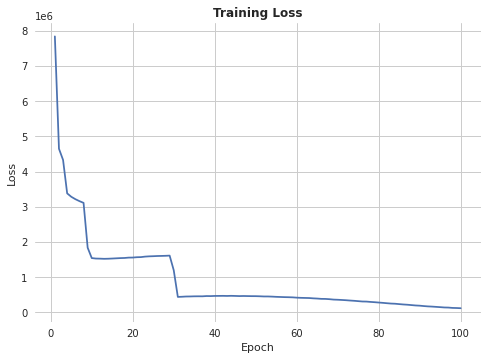

In [ ]:
# 손실함수 그래프 표현
plt.plot(range(1, model.epochs+1), model.callbacks[0].training_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss", fontweight = "bold")
plt.show()

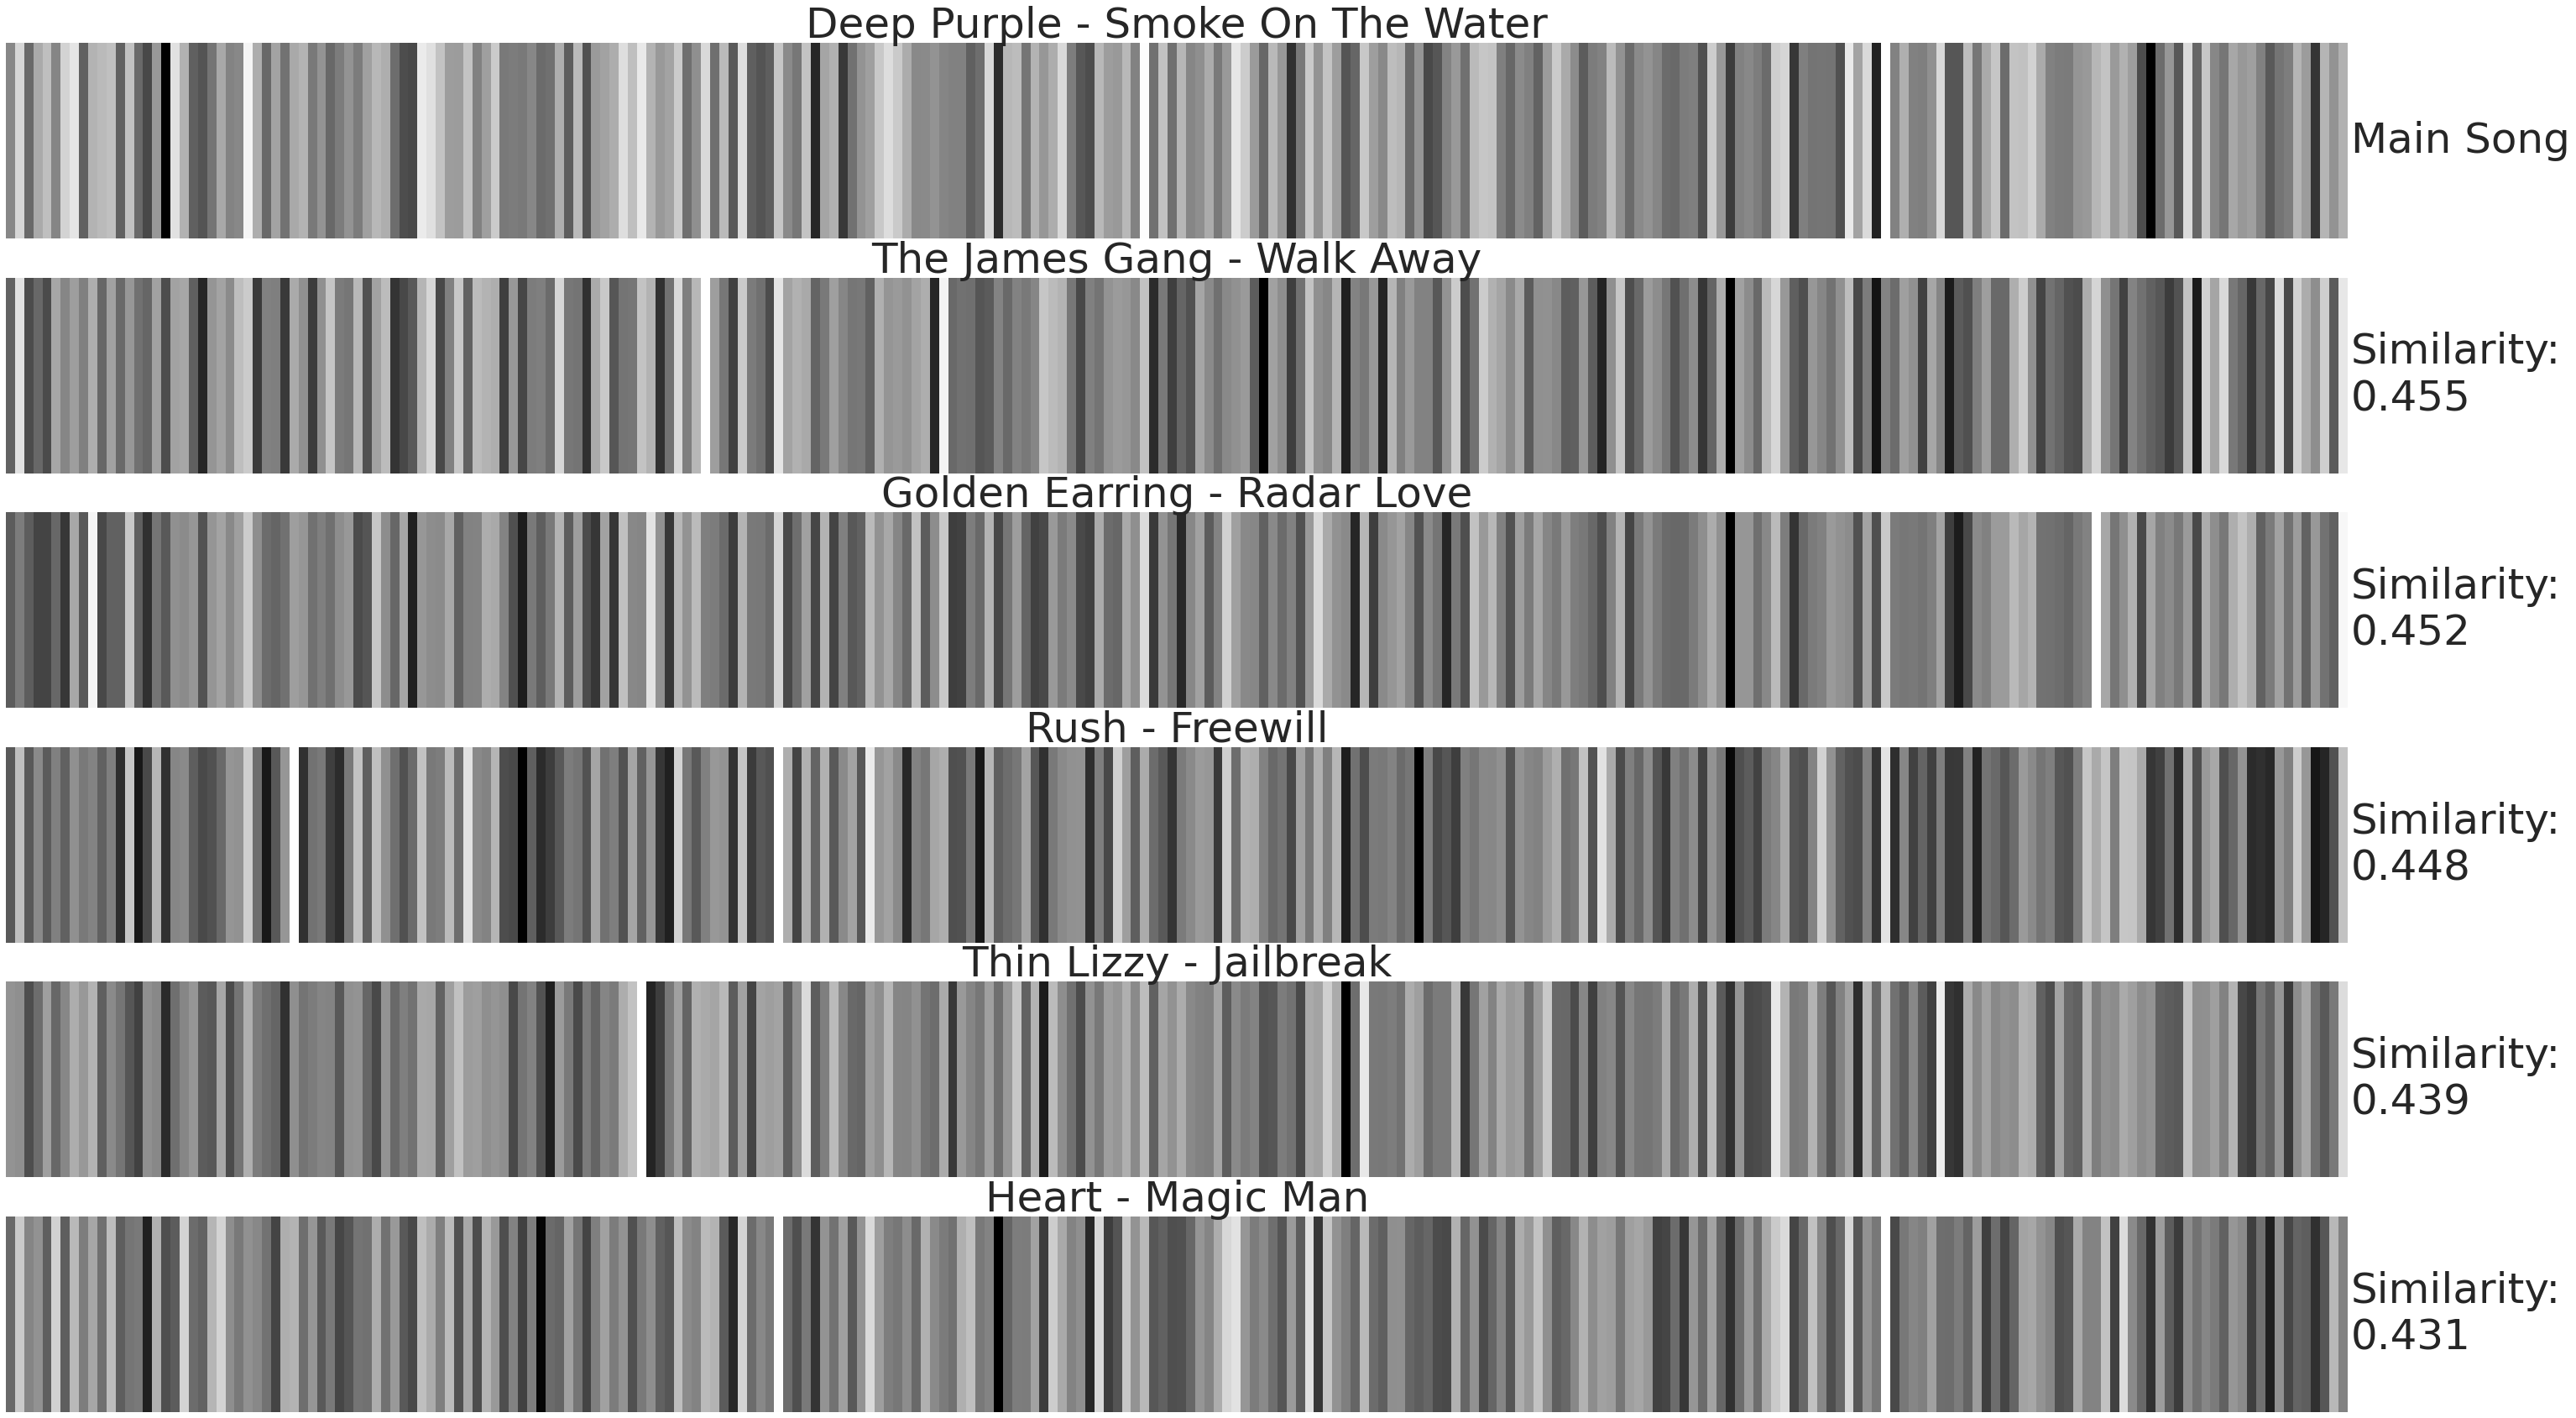

In [ ]:
# 벡터 시각화 (코사인 유사도)
fig, axes = plt.subplots(6, 1, figsize = (50, 30))

slug = '2635' # longview - green day 1876
song_id_list = [(slug, "Main Song"), *[t for t in model.wv.most_similar(slug)[:5]]]

for ax, (song_id, sim) in zip(axes.flat, song_id_list):
    ax.imshow([model.wv[song_id]], cmap = "binary", aspect = "auto")
    ax.set_title(songs.loc[song_id, "artist - title"], fontsize = 50)
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"Similarity:\n{sim:.3f}" if sim != song_id_list[0][1] else sim,
                  rotation = "horizontal", ha = "left", va = "center", fontsize = 50)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show() # 유사한 것들 그림으로 보여줌

In [ ]:
# K-평균 알고리즘을 이용한 클러스터링 (코사인 유사도)

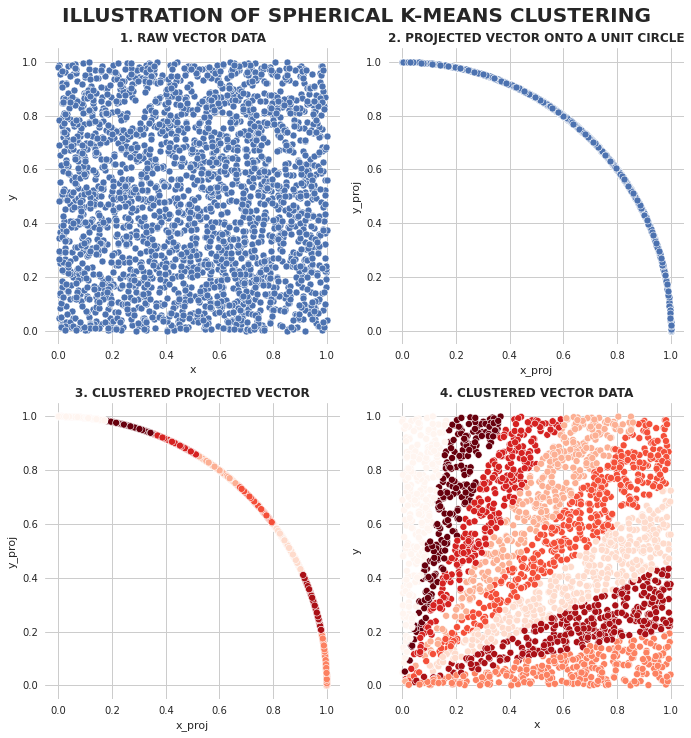

In [ ]:
# Generate random vectors
np.random.seed(123)
random_vec = np.random.uniform(0, 1, (2500, 2))
skm_test = SphericalKMeans(n_clusters = 8, n_jobs = -1,
                           random_state = 123).fit(random_vec)

normalized_random_vec = random_vec/np.linalg.norm(random_vec, axis=1, keepdims=True)
cluster_df = pd.DataFrame({'x': random_vec[:,0],
                           'y': random_vec[:,1],
                           'x_proj': normalized_random_vec[:,0],
                           'y_proj': normalized_random_vec[:,1],
                           'cluster': skm_test.labels_})

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10,10))

plot_list = [('x', 'y'), ('x_proj', 'y_proj'), ('x_proj', 'y_proj'), ('x', 'y')]
hue_list = [None, None, 'cluster', 'cluster']
title_list = ["1. RAW VECTOR DATA", "2. PROJECTED VECTOR ONTO A UNIT CIRCLE",
              "3. CLUSTERED PROJECTED VECTOR", "4. CLUSTERED VECTOR DATA"]

for ax, (x,y), hue, title in zip(axes.flat, plot_list, hue_list, title_list):
    sns.scatterplot(data = cluster_df,
                    x = x, y = y, hue = hue,
                    palette = "Reds", legend = False,
                    ax = ax)
    ax.set_title(title, fontweight = "bold")

plt.suptitle("ILLUSTRATION OF SPHERICAL K-MEANS CLUSTERING",
             fontweight = "bold", fontsize = 20, y = 1.02)
plt.tight_layout()
plt.show()

In [ ]:
#  클러스터링 훈련부

In [ ]:
# elbow method로 10 ~ 500 클러스터링
embedding_matrix = model.wv[model.wv.vocab.keys()]
embedding_matrix.shape

(72047, 256)

In [ ]:
# 실행 금지 (XXX)

In [ ]:
range_k_clusters = (10, 500)
skm_list = []
for k in tqdm(range(*range_k_clusters, 10)):
    skm = SphericalKMeans(n_clusters = k,
                          n_init = 5, n_jobs = -1,
                          random_state = 123).fit(embedding_matrix)

    result_dict = {
        "k": k,
        "WCSS": skm.inertia_,
        "skm_object": skm
    }

    skm_list.append(result_dict)
skm_df = pd.DataFrame(skm_list).set_index('k')
skm_df.head()

In [ ]:
# 여기까진 클릭 XXXX

In [ ]:
def save2Pickle(obj, filename):
    with open(f"{MODEL_PATH}{filename}.pkl", "wb") as file:
        pickle.dump(obj, file)

def loadPickle(filename):
    with open(f"{MODEL_PATH}{filename}.pkl", "rb") as file:
        return pickle.load(file)

In [ ]:
# 클러스터링 데이터 저장부, 실행 금지 (XXX)
save2Pickle(skm_df, "skm_cluster")

In [ ]:
# 여기까진 클릭 XXXX

In [ ]:
skm_df = loadPickle("skm_cluster")

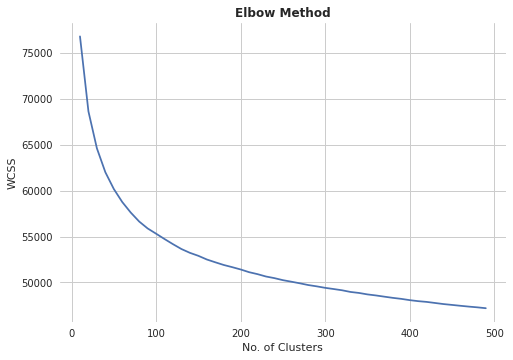

In [ ]:
skm_df.WCSS.plot()
plt.xlabel("No. of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method", fontweight = "bold")
plt.show()

In [ ]:
def locateOptimalElbow(x, y):
    # START AND FINAL POINTS
    p1 = (x[0], y[0])
    p2 = (x[-1], y[-1])

    # EQUATION OF LINE: y = mx + c
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])
    c = (p2[1] - (m * p2[0]))

    # DISTANCE FROM EACH POINTS TO LINE mx - y + c = 0
    a, b = m, -1
    dist = np.array([abs(a*x0+b*y0+c)/math.sqrt(a**2+b**2) for x0, y0 in zip(x,y)])
    return x[np.argmax(dist)]

In [ ]:
k_opt = locateOptimalElbow(skm_df.index, skm_df['WCSS'].values)
skm_opt = skm_df.loc[k_opt, "skm_object"]
skm_opt

SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=90,
                n_init=5, n_jobs=-1, normalize=True, random_state=123,
                tol=0.0001, verbose=0)

In [ ]:
songs_cluster = songs.copy()
songs_cluster.loc[model.wv.vocab.keys(), 'cluster'] = skm_opt.labels_
songs_cluster['cluster'] = songs_cluster['cluster'].fillna(-1).astype('int').astype('category')

In [ ]:
# 시각적 군집화 실행 금지 (XXX)

In [ ]:
embedding_tsne = TSNE(n_components = 2, metric = 'cosine',
                      random_state = 123).fit_transform(embedding_matrix)

In [ ]:
save2Pickle(embedding_tsne, "tsne_viz")

In [ ]:
# 여기까진 실행 XXX

In [ ]:
# 110 clusters of Song2Vec

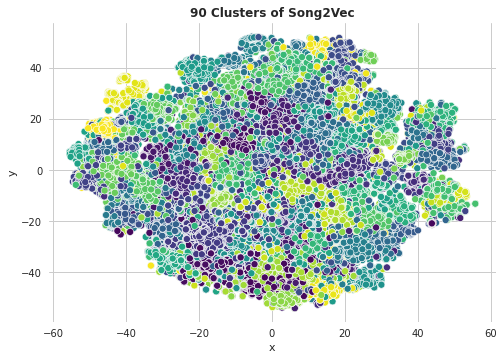

In [ ]:
embedding_tsne = loadPickle("tsne_viz")
songs_cluster.loc[model.wv.vocab.keys(), 'x'] = embedding_tsne[:,0]
songs_cluster.loc[model.wv.vocab.keys(), 'y'] = embedding_tsne[:,1]
sns.scatterplot(data = songs_cluster[songs_cluster['cluster'] != -1],
                x = 'x', y = 'y', palette = "viridis",
                hue = 'cluster', legend = False).set_title(f"{k_opt} Clusters of Song2Vec",
                                                           fontweight = "bold")
plt.show()

In [ ]:
# Randomly selected 10 clusters of Song2Vec

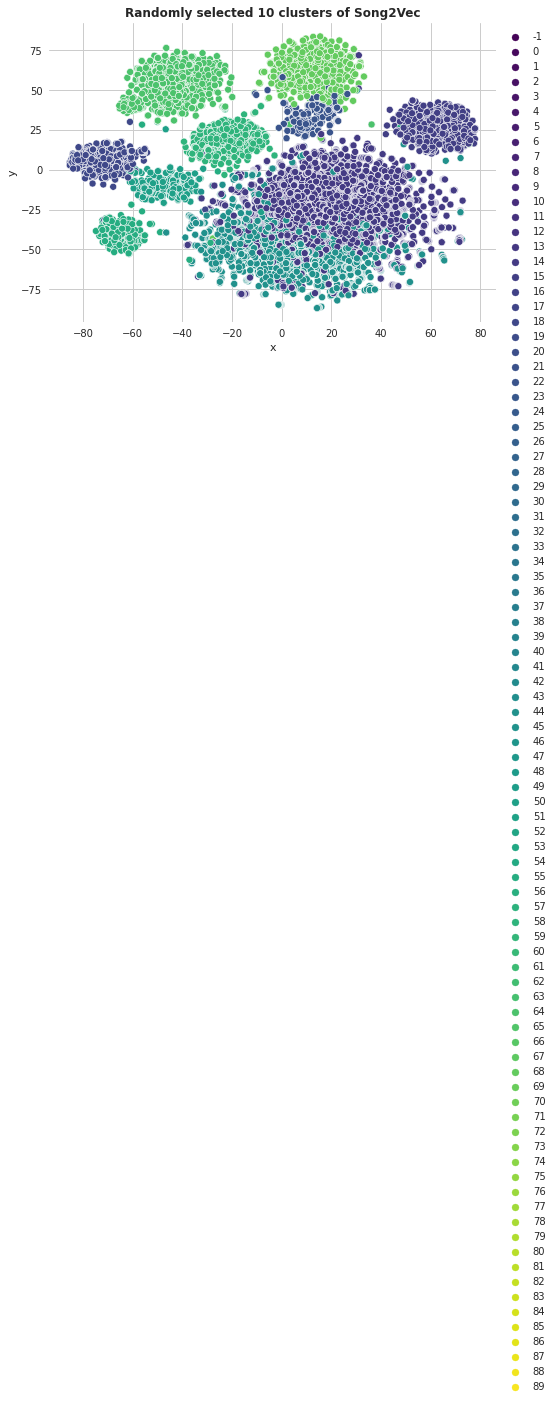

In [ ]:
random.seed(100)
random_cluster2plot = random.sample(range(k_opt), 10)
random_songs = songs_cluster[songs_cluster.cluster.isin(random_cluster2plot)].copy()
random_tsne = TSNE(n_components = 2, metric = 'cosine',
                   random_state = 100).fit_transform(model.wv[random_songs.index])
random_songs.loc[random_songs.index, 'x'] = random_tsne[:,0]
random_songs.loc[random_songs.index, 'y'] = random_tsne[:,1]

g = sns.scatterplot(data = random_songs,
                x = 'x', y = 'y', palette = "viridis",
                hue = 'cluster')
g.legend(loc = "upper left", bbox_to_anchor = (1, 1))
g.set_title(f"Randomly selected {len(random_cluster2plot)} clusters of Song2Vec", fontweight = "bold")
plt.show()

In [ ]:
# 평균 벡터 방식 추천

In [ ]:
def meanVectors(playlist):
    vec = []
    for song_id in playlist:
        try:
            vec.append(model.wv[song_id])
        except KeyError:
            continue
    return np.mean(vec, axis=0)

In [ ]:
playlist_vec = list(map(meanVectors, playlist_test))

In [ ]:
# 각 벡터별 유사도 상위 추천방식

In [ ]:
def similarSongsByVector(vec, n = 10, by_name = True):
    # extract most similar songs for the input vector
    similar_songs = model.wv.similar_by_vector(vec, topn = n)

    # extract name and similarity score of the similar products
    if by_name:
        similar_songs = [(songs.loc[song_id, "artist - title"], sim)
                              for song_id, sim in similar_songs]

    return similar_songs

In [ ]:
# 출력 담당 함수, 아티스트 적으면 상위 n개 추천해준다.

In [ ]:
def print_recommended_songs(idx, n):
    print("============================")
    print("SONGS PLAYLIST")
    print("============================")
    for song_id in playlist_test[idx]:
        print(songs.loc[song_id, "artist - title"])
    print()
    print("============================")
    print(f"TOP {n} RECOMMENDED SONGS")
    print("============================")
    for song, sim in similarSongsByVector(playlist_vec[idx], n):
        print(f"[Similarity: {sim:.3f}] {song}")
    print("============================")

In [ ]:
print_recommended_songs(idx = 305, n = 10)

SONGS PLAYLIST
Selena - Como La Flor
The Texas Tornados - Who Were You Thinkin' Of
Selena - Sentimientos

TOP 10 RECOMMENDED SONGS
[Similarity: 0.805] Selena - Como La Flor
[Similarity: 0.747] Little Joe Y La Familia - Borrachera
[Similarity: 0.740] Selena - Sentimientos
[Similarity: 0.721] Jennifer Y Los Jetz - Me Piden
[Similarity: 0.718] Tierra Tejana - Eres Casado
[Similarity: 0.714] Lorenzo Antonio - Con La Misma Espina
[Similarity: 0.708] Sparx - Lo Dice Mi Corazon
[Similarity: 0.704] The Texas Tornados - Who Were You Thinkin' Of
[Similarity: 0.695] Fama - Sirveme Tequila
[Similarity: 0.694] Sparx - Ven


In [ ]:
# 각 방식 평가하기

In [ ]:
# 상위 25개 노래
top_n_songs = 25

In [ ]:
# "랜덤 방식 추천"에서 HitRate 계산함수

In [ ]:
def hitRateRandom(playlist, n_songs):
    hit = 0
    for i, target in enumerate(playlist):
        random.seed(i)
        recommended_songs = random.sample(list(songs.index), n_songs)
        hit += int(target in recommended_songs)
    return hit/len(playlist)

In [ ]:
eval_random = pd.Series([hitRateRandom(p, n_songs = top_n_songs)
                         for p in tqdm(playlist_test, position=0, leave=True)])
eval_random.mean()

100%|██████████| 1000/1000 [17:50<00:00,  1.07s/it]


0.0003041373138091042

In [ ]:
# "태그 방식 추천"에서 HitRate 계산함수

In [ ]:
# 태그 맵핑
mapping_tag2song = songs.explode('tag_names').reset_index().groupby('tag_names')['song_id'].apply(list)
mapping_tag2song

tag_names
00s           [16, 23, 28, 30, 38, 41, 46, 49, 55, 58, 68, 8...
10s           [6, 13, 14, 18, 19, 27, 46, 51, 57, 59, 60, 62...
1960s         [516, 612, 622, 626, 629, 897, 1336, 1337, 137...
1970s         [499, 500, 522, 537, 608, 615, 618, 619, 881, ...
1980s         [501, 502, 536, 556, 618, 837, 1378, 1505, 150...
                                    ...                        
usa           [47, 52, 91, 187, 194, 197, 201, 298, 324, 382...
vocal         [14, 91, 96, 97, 125, 194, 201, 386, 407, 424,...
vocal jazz    [42, 592, 599, 872, 908, 1043, 1097, 1104, 117...
wjlb-fm       [0, 1, 2, 4, 5, 6, 8, 14, 18, 19, 20, 22, 25, ...
worship       [104, 106, 384, 566, 643, 732, 737, 1109, 1115...
Name: song_id, Length: 251, dtype: object

In [ ]:
def hitRateContextSongTag(playlist, window, n_songs):
    hit = 0
    context_target_list = [([playlist[w] for w in range(idx-window, idx+window+1)
                             if not(w < 0 or w == idx or w >= len(playlist))], target)
                           for idx, target in enumerate(playlist)]
    for i, (context, target) in enumerate(context_target_list):
        context_song_tags = set(songs.loc[context, 'tag_names'].explode().values)
        possible_songs_id = set(mapping_tag2song[context_song_tags].explode().values)

        random.seed(i)
        recommended_songs = random.sample(possible_songs_id, n_songs)
        hit += int(target in recommended_songs)
    return hit/len(playlist)

In [ ]:
eval_song_tag = pd.Series([hitRateContextSongTag(p, model.window, n_songs = top_n_songs)
                           for p in tqdm(playlist_test, position=0, leave=True)])
eval_song_tag.mean()

100%|██████████| 1000/1000 [1:36:14<00:00,  5.77s/it]


0.00040405659266796947

In [ ]:
# "클러스터 방식 추천"에서 HitRate 계산함수

In [ ]:
def hitRateClustering(playlist, window, n_songs):
    hit = 0
    context_target_list = [([playlist[w] for w in range(idx-window, idx+window+1)
                             if not(w < 0 or w == idx or w >= len(playlist))], target)
                           for idx, target in enumerate(playlist)]
    for context, target in context_target_list:
        cluster_numbers = skm_opt.predict([model.wv[c] for c in context if c in model.wv.vocab.keys()])
        majority_voting = stats.mode(cluster_numbers).mode[0]
        possible_songs_id = list(songs_cluster[songs_cluster['cluster'] == majority_voting].index)
        recommended_songs = random.sample(possible_songs_id, n_songs)
        songs_id = list(zip(*recommended_songs))[0]
        hit += int(target in songs_id)
    return hit/len(playlist)

In [ ]:
eval_clust = pd.Series([hitRateClustering(p, model.window, n_songs = top_n_songs)
                           for p in tqdm(playlist_test, position=0, leave=True)])
eval_clust.mean()

100%|██████████| 1000/1000 [08:25<00:00,  1.98it/s]


0.005091079571459293

In [ ]:
# "Song2Vec 방식 추천"에서 HitRate 계산함수

In [ ]:
def hitRateSong2Vec(playlist, window, n_songs):
    hit = 0
    context_target_list = [([playlist[w] for w in range(idx-window, idx+window+1)
                             if not(w < 0 or w == idx or w >= len(playlist))], target)
                           for idx, target in enumerate(playlist)]
    for context, target in context_target_list:
        context_vector = meanVectors(context)
        recommended_songs = similarSongsByVector(context_vector, n = n_songs, by_name = False)
        songs_id = list(zip(*recommended_songs))[0]
        hit += int(target in songs_id)
    return hit/len(playlist)

In [ ]:
eval_song2vec = pd.Series([hitRateSong2Vec(p, model.window, n_songs = top_n_songs)
                           for p in tqdm(playlist_test, position=0, leave=True)])
eval_song2vec.mean()

100%|██████████| 1000/1000 [25:28<00:00,  1.53s/it]


0.11916792604879002

In [ ]:
# 비교하기

In [ ]:
eval_df = pd.concat([eval_random.rename("Random"),
           eval_song_tag.rename("Song Tag"),
           eval_clust.rename("Clustering"),
           eval_song2vec.rename("Song2Vec")], axis = 1)
save2Pickle(eval_df, "eval_df")

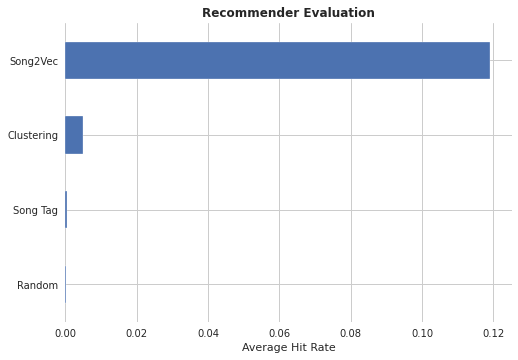

In [ ]:
# 비교표
eval_df = loadPickle("eval_df")
g = eval_df.mean().sort_values().plot(kind = 'barh')
g.set_xlabel("Average Hit Rate")
g.set_title("Recommender Evaluation", fontweight = "bold")
plt.show()